In [ ]:
# %%
"""
Notebook: Buoy Training & Prediction Pipeline
Author: Antonio Bueno Anton
Updated: 2025‑05‑15

Summary
-------
* Loads the **merged** parquet file (`processed/buoy_all_YYYYMMDDTHHMMSSZ.parquet`).
* Builds a very simple model (linear regression).  
  – Feel free to replace with something more powerful.
* Writes two artefacts back to S3:
    1. **Predictions** → `predictions/pred_<timestamp>.parquet`
    2. **Model**       → `model/model_<timestamp>.joblib`
* Provides an inline plot of *Actual vs. Prediction* (handles 1 or many rows).

Customise the following parameters near the top:
```python
bucket = "oes-buoy-data-eu-west-3-dev"
input_key = "processed/buoy_all_20250515T181439Z.parquet"  # <-- point to latest file
```

If the dataset grows, you can switch to a `train/test` split and additional
features – the rest of the pipeline will still work.
"""

# %%

'\nNotebook: Buoy Training & Prediction Pipeline\nAuthor: ChatGPT\nUpdated: 2025‑05‑15\n\nSummary\n-------\n* Loads the **merged** parquet file (`processed/buoy_all_YYYYMMDDTHHMMSSZ.parquet`).\n* Builds a very simple model (linear regression).  \n  –\xa0Feel free to replace with something more powerful.\n* Writes two artefacts back to S3:\n    1. **Predictions** → `predictions/pred_<timestamp>.parquet`\n    2. **Model**       → `model/model_<timestamp>.joblib`\n* Provides an inline plot of *Actual vs. Prediction* (handles 1\xa0or many rows).\n\nCustomise the following parameters near the top:\n```python\nbucket = "oes-buoy-data-eu-west-3-dev"\ninput_key = "processed/buoy_all_20250515T181439Z.parquet"  # <-- point to latest file\n```\n\nIf the dataset grows, you can switch to a `train/test` split and additional\nfeatures – the rest of the pipeline will still work.\n'

In [45]:
# Installation 
!pip install pandas pyarrow s3fs scikit-learn joblib

In [46]:
import io
import datetime as dt
import pandas as pd
import boto3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import joblib

In [47]:
# Parameters -------------------------------------------------------------
bucket = "oes-buoy-data-eu-west-3-dev"
input_key = "processed/buoy_all_20250515T181439Z.parquet"  # update to latest file
predictions_prefix = "predictions/"
model_prefix = "model/"


In [48]:
# Target column ----------------------------------------------------------
target_column = "sea_temp_c"  # adjust to your column name

In [49]:
# Load data --------------------------------------------------------------
print("Reading parquet from S3…")
df = pd.read_parquet(f"s3://{bucket}/{input_key}", engine="pyarrow")
print("DataFrame shape:", df.shape)

Reading parquet from S3…
DataFrame shape: (26, 7)


In [50]:
# Display first rows (IPython optional)
try:
    from IPython.display import display
    display(df.head())
except ImportError:
    print(df.head())

,buoy_id,timestamp,sea_temp_c,wave_height_m,current_speed_kph,location.lat,location.lon
0,buoy-009081,2025-05-05T08:00:49.874432,11.57,2.06,2.77,53.51742,-6.58656
1,buoy-0f3f23,2025-04-21T08:00:49.903113,15.96,1.49,4.10,57.62280,2.18848
2,buoy-54cdf9,2025-04-04T18:08:41.505056,16.12,2.43,2.40,55.02346,-2.50621
3,buoy-bbb0e8,2025-04-14T08:00:49.897273,16.48,1.88,3.77,48.33923,-3.54033
4,buoy-e687b0,2025-04-28T08:00:49.930235,10.75,3.00,3.95,58.45904,-7.23199


In [51]:
# Ensure target exists ---------------------------------------------------
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found. Available: {list(df.columns)}")

In [52]:
# Feature engineering ----------------------------------------------------
# Basic timestamp features if 'timestamp' column exists
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["hour"] = df["timestamp"].dt.hour
    df["dayofyear"] = df["timestamp"].dt.dayofyear
    feature_cols = ["hour", "dayofyear"]
else:
    # Fallback to simple index feature
    df["idx"] = np.arange(len(df))
    feature_cols = ["idx"]

X = df[feature_cols]
y = df[target_column]


In [53]:
# Train/test split -------------------------------------------------------
if len(df) > 4:  # arbitrary threshold; skip split if dataset is tiny
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = X, X, y, y  # trivial split


In [54]:
# Model training ---------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# In‑sample / test predictions ------------------------------------------
df["prediction"] = model.predict(X)

In [56]:
# Evaluate ---------------------------------------------------------------
mae = mean_absolute_error(y_test, model.predict(X_test))
r2 = r2_score(y_test, model.predict(X_test))
print(f"MAE: {mae:.3f} | R²: {r2:.3f}")

MAE: 2.091 | R²: -0.580


In [57]:
# Save predictions to S3 --------------------------------------------------
s3 = boto3.client("s3")

timestamp = dt.datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

pred_key = f"{predictions_prefix}pred_{timestamp}.parquet"

buffer = io.BytesIO()
df[["prediction"]].to_parquet(buffer, index=False, engine="pyarrow")
buffer.seek(0)

s3.put_object(Bucket=bucket, Key=pred_key, Body=buffer.getvalue())
print(f"Predictions saved to s3://{bucket}/{pred_key}")


Predictions saved to s3://oes-buoy-data-eu-west-3-dev/predictions/pred_20250515T182302Z.parquet


/tmp/ipykernel_118/2605291072.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = dt.datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


In [58]:
# Save model to S3 (model/ folder) --------------------------------------
model_buffer = io.BytesIO()
joblib.dump(model, model_buffer)
model_buffer.seek(0)

model_key = f"{model_prefix}model_{timestamp}.joblib"

s3.put_object(Bucket=bucket, Key=model_key, Body=model_buffer.getvalue())
print(f"Model saved to s3://{bucket}/{model_key}")


Model saved to s3://oes-buoy-data-eu-west-3-dev/model/model_20250515T182302Z.joblib


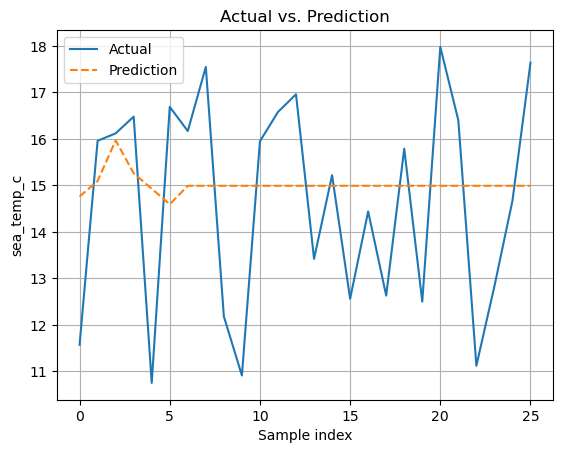

In [59]:
# Visualisation ----------------------------------------------------------
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError("matplotlib not installed – run `pip install matplotlib` and retry.")

plt.figure()
if len(df) > 1:
    plt.plot(df.index, y, label="Actual")
    plt.plot(df.index, df["prediction"], label="Prediction", linestyle="--")
else:
    plt.scatter(df.index, y, label="Actual", marker="o")
    plt.scatter(df.index, df["prediction"], label="Prediction", marker="x")
    plt.xlim(-1, 1)

plt.xlabel("Sample index")
plt.ylabel(target_column)
plt.title("Actual vs. Prediction")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
print("Pipeline finished!")

Pipeline finished!
